In [1]:
import os
import os.path as osp
import numpy as np
import math

from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

import torchvision
import torchvision.transforms as transforms


IMG_HEIGHT = 256  
IMG_WIDTH = 512
NUM_CLASSES = 20
IGNORE_INDEX = 255
BATCH_SIZE = 8 
LEARNING_RATE = 0.002
EPOCHS = 20

# Segmentation classes. All invalid classes will be ignored.  
invalid_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [IGNORE_INDEX, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']

# This dictionary is used to encode all classes with 20 classes. 
class_dict = dict(zip(valid_classes, range(len(valid_classes))))
num_classes=len(valid_classes)

# Colors for different classes to be used for segmentation. 
colors = [[0, 0, 0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
]

# Dictionary of colors for labels.
label_colours_dict = dict(zip(range(num_classes), colors))   

# Transformations to apply to the images. Resize the image to 256x512.
tfms = transforms.Compose([transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST), transforms.PILToTensor()])

# Use fine mode.
train_dataset = torchvision.datasets.Cityscapes('./', split='train', mode='fine', target_type='semantic', transform=tfms, target_transform=tfms)

val_dataset = torchvision.datasets.Cityscapes('./', split='val', mode='fine', target_type='semantic', transform=tfms, target_transform=tfms)

test_dataset = torchvision.datasets.Cityscapes('./', split='test', mode='fine', target_type='semantic', transform=tfms, target_transform=tfms)

/tmp/ipykernel_933/35633949.py:68: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  tfms = transforms.Compose([transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST), transforms.PILToTensor()])
/home/tarun/miniconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


torch.Size([3, 256, 512]) torch.Size([1, 256, 512])


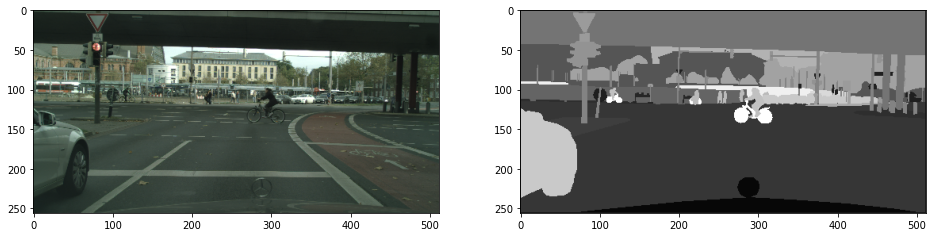

In [2]:
img, seg = train_dataset[10]
print(img.shape,seg.shape)
fig,ax=plt.subplots(ncols=2,figsize=(16,8))
ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(torch.squeeze(seg, 0), cmap='gray')

In [3]:
def update_classes_seg(img):
    #remove unwanted classes and recitify the labels of wanted classes
    for invalid in invalid_classes:
        img[img == invalid] = IGNORE_INDEX
    for valid in valid_classes:
        img[img == valid] = class_dict[valid]
    return img


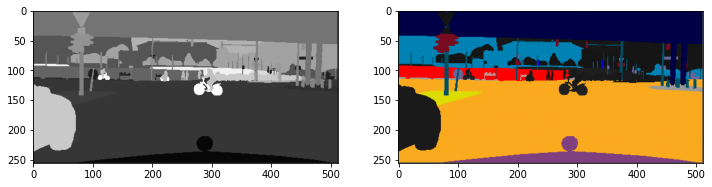

In [4]:
def color_seg(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, num_classes):
        r[temp == l] = label_colours_dict[l][0]
        g[temp == l] = label_colours_dict[l][1]
        b[temp == l] = label_colours_dict[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


#let do coloring
res1=color_seg(torch.squeeze(seg, 0).clone())
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(torch.squeeze(seg, 0),cmap='gray')
ax[1].imshow(res1)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device = ", DEVICE)

Device =  cuda


In [6]:
# Double convolution block.
class Conv2x_Block(torch.nn.Module):
    def __init__(self, inChannelCount, outChannelCount):
        super().__init__()
        self.conv2x = nn.Sequential(
            # Remove bias if adding batchnorm later.
            nn.Conv2d(inChannelCount, outChannelCount, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(outChannelCount),
            nn.ReLU(),
            nn.Conv2d(outChannelCount, outChannelCount, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(outChannelCount),
            nn.ReLU()
        )

    def forward(self, X):
        X = self.conv2x(X)
        return X

class UNet_Encoder(torch.nn.Module):
    def __init__(self, channels_per_layer=[3, 64, 128, 256, 512, 1024]):
        super().__init__()
        self.encoder_conv2x = torch.nn.ModuleList(
            [Conv2x_Block(channels_per_layer[i], channels_per_layer[i+1]) for i in range(0, len(channels_per_layer) - 1)]
        )
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, X):
        self.residual_layers_output = []
        for conv_block in self.encoder_conv2x:
            X = conv_block(X)
            if conv_block != self.encoder_conv2x[-1]:
                self.residual_layers_output.append(X)
            X = self.max_pool(X)
        return X, self.residual_layers_output


class UNet_Decoder(torch.nn.Module):
    def __init__(self, channels_per_layer=[1024, 512, 256, 128, 64]):
        super().__init__()
        self.channels_per_layer = channels_per_layer
        self.transpose_conv = torch.nn.ModuleList(
			[nn.ConvTranspose2d(channels_per_layer[i], channels_per_layer[i + 1], kernel_size=2, stride=2) for i in range(0, len(channels_per_layer) - 1)])
			 	
        self.decoder_conv2x = torch.nn.ModuleList(
            [Conv2x_Block(channels_per_layer[i], channels_per_layer[i+1]) for i in range(0, len(channels_per_layer) - 1)]
        )
        

    def forward(self, X, encoder_layers_output):
        for trans_conv,  conv2x, encoder_layer in zip(self.transpose_conv, self.decoder_conv2x, encoder_layers_output):
            X = trans_conv(X)

            if X.shape != encoder_layer.shape:
                X = transforms.functional.resize(X, encoder_layer.shape[2:])

            X_concatenated = torch.cat((encoder_layer, X), dim = 1)
            X = conv2x(X_concatenated)
        return X

class UNet(torch.nn.Module):
    def __init__(self):
          super().__init__()
          self.encoder = UNet_Encoder()
          self.decoder = UNet_Decoder()
          self.final_conv = nn.Conv2d(64, 20, kernel_size=1)

    def forward(self, X):
        # print("Shape of X = ", X.shape)
        # print("type of X = ", type(X))
        X_encoded, encoder_layers_output = self.encoder(X)
        X_decoded = self.decoder(X_encoded, encoder_layers_output[::-1])
        out = self.final_conv(X_decoded)
        return out


In [7]:
def val_accuracy(model, val_loader):
  model.eval()
  batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
  num_correct = 0
  for i, (x, y) in enumerate(val_loader):

    x = x.float().cuda()
    y = y.float().cuda()
    y=update_classes_seg(y)
    y = torch.squeeze(y,1)

    with torch.no_grad():
      outputs = model(x)

    num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
    batch_bar.set_postfix(val_acc="{:.04f}%".format(100 * num_correct / ((i + 1) * BATCH_SIZE * IMG_HEIGHT * IMG_WIDTH)))
    batch_bar.update()
      
  
  # batch_bar.close()
  print("Validation Accuracy: {:.04f}%".format((100 * num_correct) / (len(valDataset) * IMG_HEIGHT * IMG_WIDTH)))
#   return 100 * num_correct / len(valDataset)

In [8]:
def train_function(data, model, optimizer, loss_fn, scheduler, device):
    loss_values = []
    # data = tqdm(data)
    
    num_correct = 0
    total_loss = 0
    
    batch_bar = tqdm(total=len(data), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    for index, batch in enumerate(data): 
        X, y = batch
        y=update_classes_seg(y)
        # print(torch.unique(y))
        X, y = X.float().to(device), y.long().to(device)
        preds = model(X)

        y = torch.squeeze(y,1)
        loss = loss_fn(preds, y)

        num_correct += int((torch.argmax(preds, axis=1) == y).sum())
        total_loss += float(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / ((index + 1) * BATCH_SIZE * IMG_HEIGHT * IMG_WIDTH)),
            loss="{:.04f}".format(float(total_loss / (index + 1))),
            lr=scheduler.get_last_lr())
        batch_bar.update()
    batch_bar.close()
    scheduler.step()
    print("Training Accuracy: {:.04f}%".format(100 * num_correct / (len(train_dataset) * IMG_HEIGHT * IMG_WIDTH)))
    return total_loss

def main():
    global epoch
    epoch = 0 

    train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size = BATCH_SIZE)
    val_dataloader = DataLoader(val_dataset, shuffle = False, batch_size = BATCH_SIZE)
    # test_dataloader = DataLoader(testDataset, shuffle = False, batch_size = BATCH_SIZE)

    print('Data Loaded Successfully!')

    # Defining the model, optimizer and loss function
    unet = UNet().to(DEVICE).train()
    optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    loss_function = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5) 

    # # Loading a previous stored model from MODEL_PATH variable
    # if LOAD_MODEL == True:
    #     checkpoint = torch.load(MODEL_PATH)
    #     unet.load_state_dict(checkpoint['model_state_dict'])
    #     optimizer.load_state_dict(checkpoint['optim_state_dict'])
    #     epoch = checkpoint['epoch']+1
    #     LOSS_VALS = checkpoint['loss_values']
    #     print("Model successfully loaded!")    

    #Training the model for every epoch. 
    for e in range(epoch, EPOCHS):
        print(f'Epoch: {e}')
        loss_val = train_function(train_dataloader, unet, optimizer, loss_function, scheduler, DEVICE)
        print("Training Loss = ", loss_val)
        LOSS_VALS.append(loss_val) 
        val_accuracy(unet, val_dataloader)
        # print("Validation accuracy = ", val_acc)
        # torch.save({
        #     'model_state_dict': unet.state_dict(),
        #     'optim_state_dict': optimizer.state_dict(),
        #     'epoch': e,
        #     'loss_values': LOSS_VALS
        # }, MODEL_PATH)
        #


if __name__ == '__main__':
    main()

Data Loaded Successfully!
Epoch: 0


Train:   0%|          | 0/372 [00:00<?, ?it/s]